In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

In [2]:
# sim / halo info
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099' # z = 0
sim_name = 'TNG100-1'
sim_name_dark = 'TNG100-1-Dark'
# sim_name = 'TNG50-4'
# sim_name_dark = 'TNG50-4-Dark'
halo_dir = f'../data/halos/halos_{sim_name}'
halo_tag = '_nstarpartmin50_twin'
fn_dark_halo_arr = f'{halo_dir}/halos_{sim_name}{halo_tag}.npy'
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
# geo info
geo_dir = f'../data/geometric_features/geometric_features_{sim_name}'
geo_tag = '_xminPEsub_rall'
fn_geo_features = f'{geo_dir}/geometric_features{halo_tag}{geo_tag}.npy'
print(fn_geo_features)

../data/geometric_features/geometric_features_TNG100-1/geometric_features_nstarpartmin50_twin_xminPEsub_rall.npy


In [4]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(fn_geo_features)

In [5]:
n_groups = [[0,1,2], [3,4,5,6,7], [8,9,10]]
geo_feature_arr_rebinned = utils.rebin_geometric_features(geo_featurizer.geo_feature_arr, n_groups)
geo_feature_arr_pseudo = utils.transform_pseudotensors(geo_feature_arr_rebinned)

In [6]:
sim_reader = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [7]:
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')
sim_reader.add_catalog_property_to_halos('r200m')
sim_reader.add_catalog_property_to_halos('v200m')

sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_minPE_hydro')

In [8]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
r_200m = np.array([dark_halo.catalog_properties['r200m'] for dark_halo in sim_reader.dark_halo_arr])
v_200m = np.array([dark_halo.catalog_properties['v200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)
log_r_200m = np.log10(r_200m)
N_halos = len(sim_reader.dark_halo_arr)
print('N_halos:', N_halos)

N_halos: 19810


# Load structure catalog properties

In [9]:
catalog_feature_names = ['M200c', 'c200c', 'a_form', 'M_acc_dyn']
idx_nan = sim_reader.get_structure_catalog_features(catalog_feature_names)
print(sim_reader.x_catalog_features.shape)

129 halos with NaN values of structure properties detected!
(19810, 4)


In [10]:
idx_notnan = np.full(N_halos, True)
idx_notnan[idx_nan] = False

In [11]:
x_catalog_features = sim_reader.x_catalog_features[idx_notnan]
x_catalog_features[:,1] = np.log10(x_catalog_features[:,1])

## Split train-val-test

In [12]:
frac_train = 0.70
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr[idx_notnan]])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, frac_test=frac_test)

print(len(idx_train), len(idx_test), len(idx_val))

13697 3057 2927


In [13]:
log_m_200m_train = log_m_200m[idx_train]

# Set up featurizer

In [14]:
# scalar info
scalar_featurizer = ScalarFeaturizer(geo_feature_arr_pseudo)
scalar_featurizer.rescale_geometric_features(m_200m, r_200m, v_200m)

# m_dm is in units of 1/1e10, this M_tot value is already in the units we're using internally (log(M/1e10))
x_features_extra = np.vstack((m_200m, r_200m, v_200m)).T
x_features_extra = np.log10(x_features_extra)   

In [15]:
m_order_max = 2
x_order_max = 4
v_order_max = 4
scalar_tag = f'_3bins_pseudo_rescaled_mord{m_order_max}_xord{x_order_max}_vord{v_order_max}'
scalar_dir = f'../data/scalar_features/scalar_features_{sim_name}'
fn_scalar_features = f'{scalar_dir}/scalar_features{halo_tag}{geo_tag}{scalar_tag}.npy'

print('loading')
scalar_featurizer.load_features(fn_scalar_features)
print('loaded')

loading
loaded


# Check out a_form

In [16]:
a_form = x_catalog_features[:,2]

In [17]:
np.sum(np.isfinite(a_form)), len(a_form)

(19681, 19681)

Text(0, 0.5, 'number per bin')

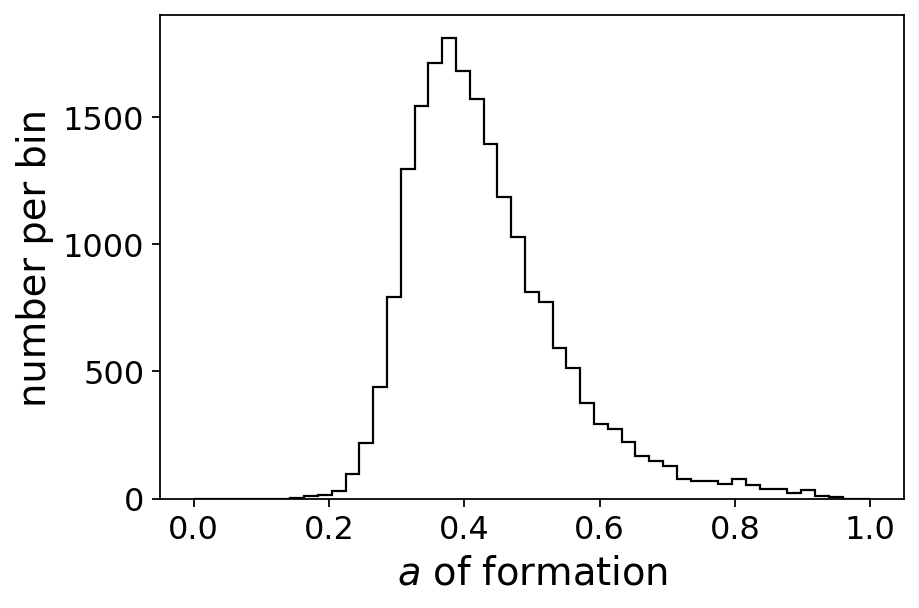

In [18]:
bins = np.linspace(0,1,50)
plt.hist(a_form, bins=bins, histtype='step', color='k')
plt.xlabel('$a$ of formation')
plt.ylabel('number per bin')

(0.0, 1.0)

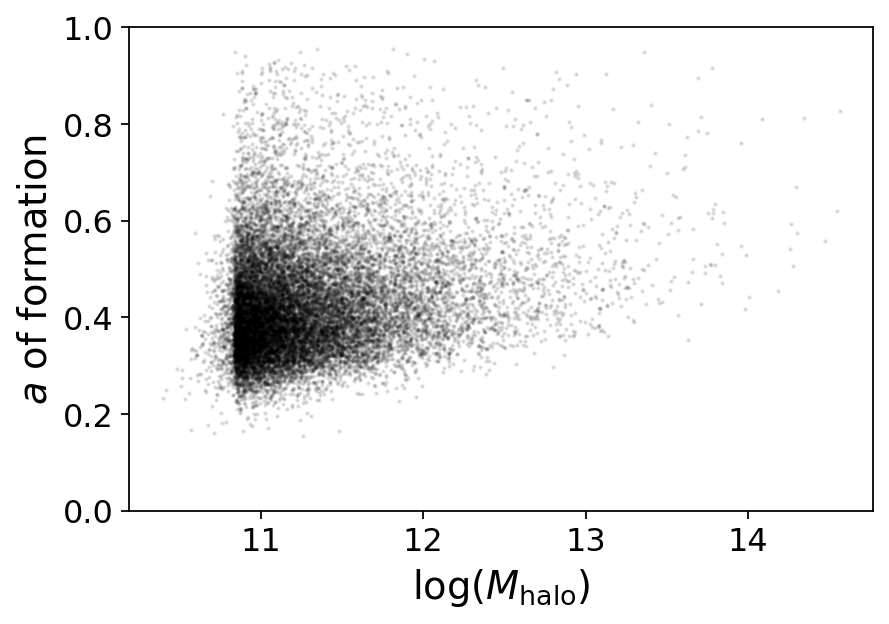

In [19]:
plt.scatter(log_m_200m[idx_notnan]+log_mass_shift, a_form, s=1, c='k', alpha=0.1)
plt.xlabel(r'log($M_\mathrm{halo}$)')
plt.ylabel('$a$ of formation')
plt.ylim(0, 1)

# Uncertainties & current val

Make some things up... 

In [20]:
uncertainties_aform = 0.1 * a_form

In [21]:
y_val_current_aform = np.ones(len(a_form))

## Go!

0.06112195255027246


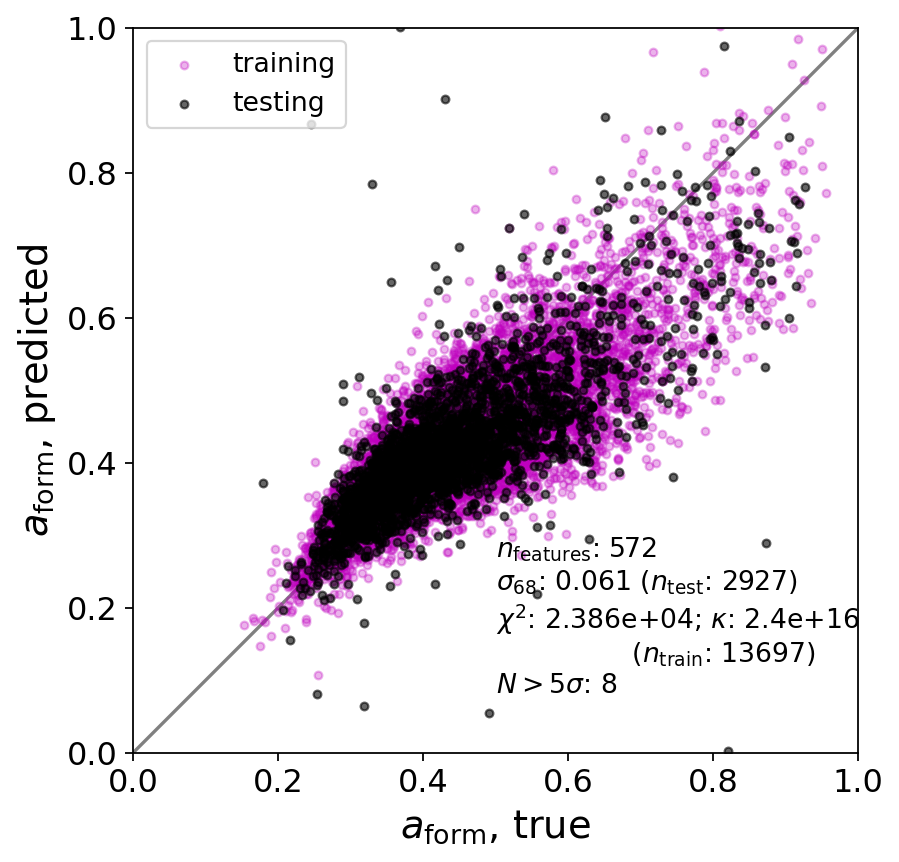

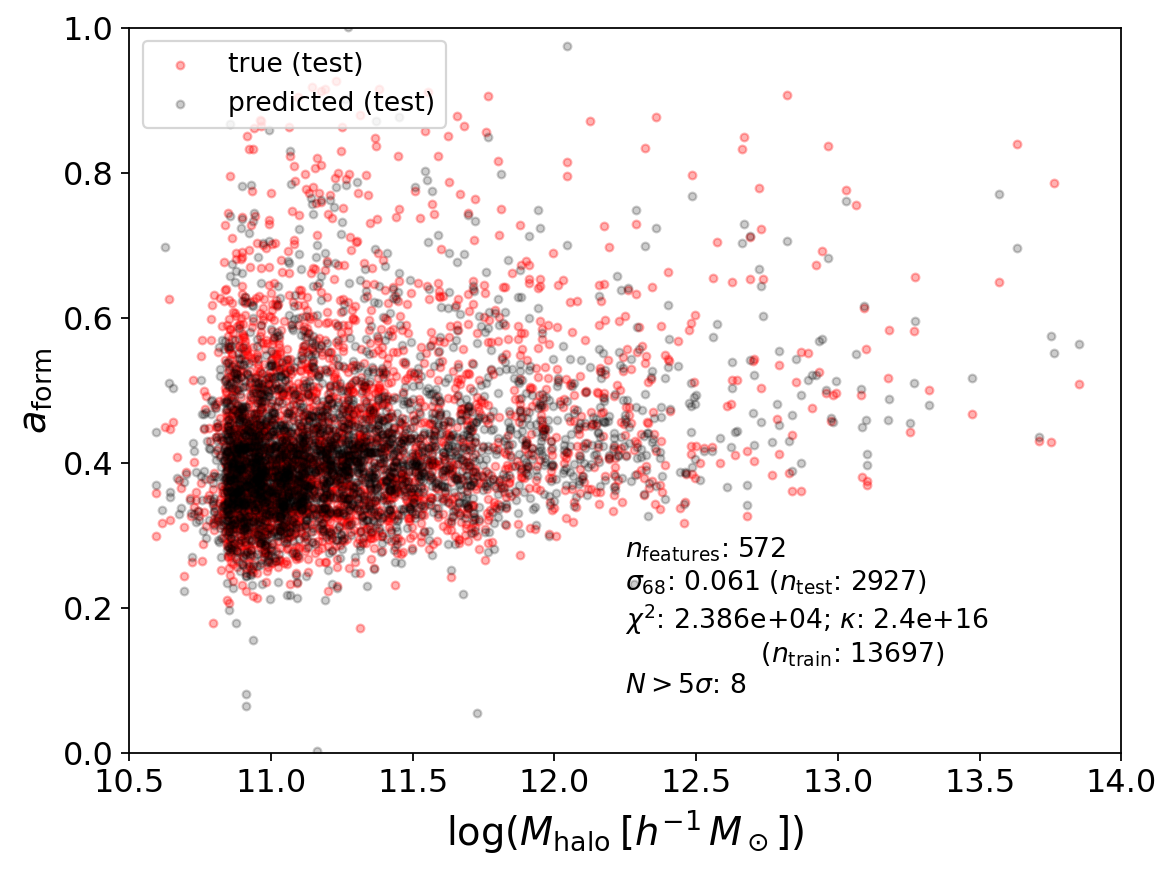

In [22]:
x_label_name = 'm_200m'
y_label_name = 'a_form'

fitter_all = LinearFitter(scalar_featurizer.scalar_features[idx_notnan], a_form, 
                    y_val_current_aform, uncertainties=uncertainties_aform,
                    x_features_extra=x_features_extra[idx_notnan])
fitter_all.split_train_test(idx_train, idx_val)
fitter_all.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter_all.predict_test()
plotter.plot_fits(x_label_name, y_label_name, fitter_all, log_m_200m, x_lim=(10.5,14),  y_lim=(0,1))
error_all, _ = utils.compute_error(fitter_all, test_error_type='percentile')
print(error_all)

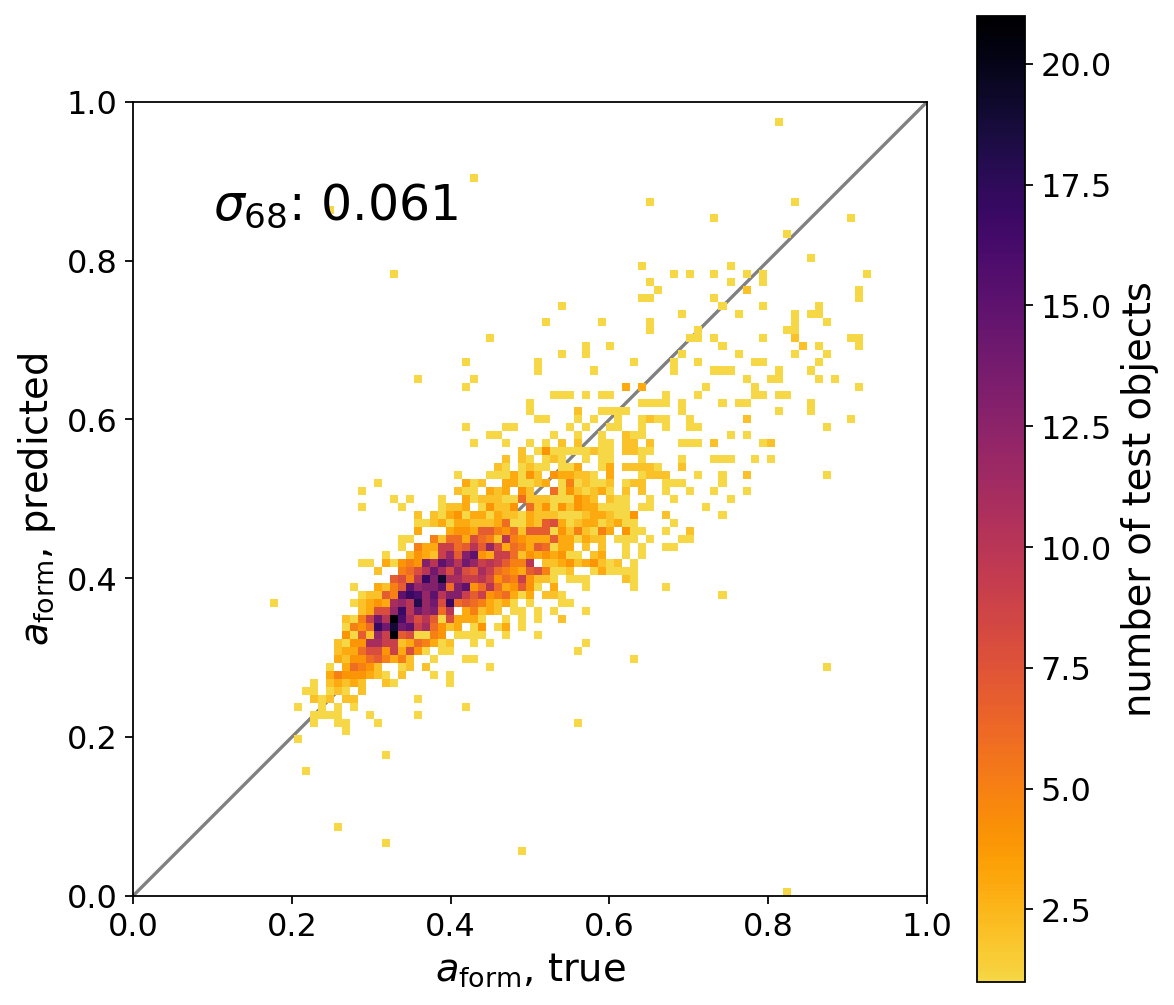

In [23]:
y_true = fitter_all.y_scalar_test
y_pred = fitter_all.y_scalar_pred
error_str = fr"$\sigma_{{68}}$: {error_all:.3f}"
plotter.plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str,
                               x_lim=(0,1),  y_lim=(0,1))

# c200c

from docs: The halo concentration, 𝑐=𝑅200c/𝑅s, where 𝑅s is computed by fitting an NFW profile to the DM density profile. We only compute c200c for halos with at least 2000 DM particles, so some halos with GroupFlag == 1 will still have missing c200c measurements.

In [24]:
y_label_name = 'c_200c'

In [25]:
log_c200c = x_catalog_features[:,1]

Text(0, 0.5, 'number per bin')

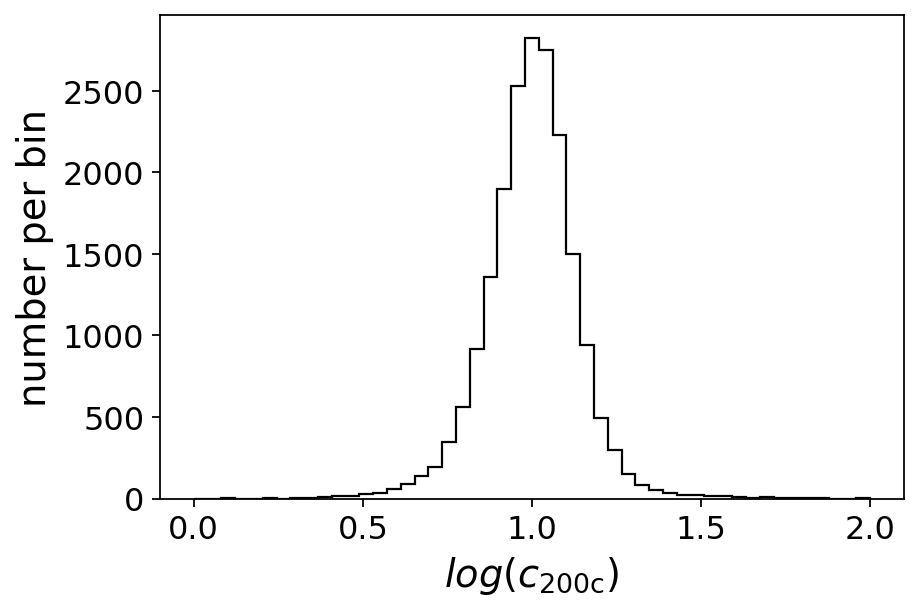

In [26]:
bins = np.linspace(0,2,50)
plt.hist(log_c200c, bins=bins, histtype='step', color='k')
plt.xlabel(utils.label_dict[y_label_name])
plt.ylabel('number per bin')

(0.0, 2.0)

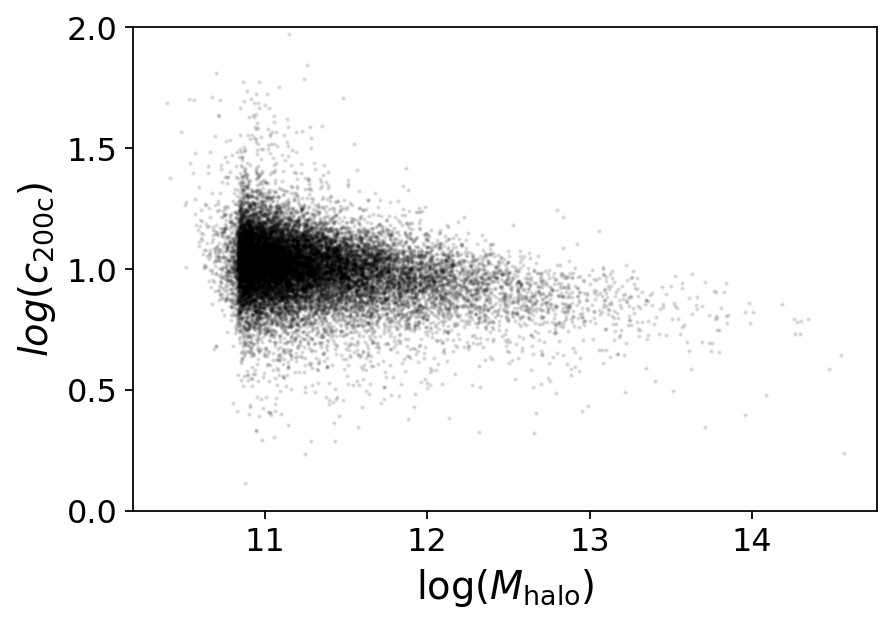

In [27]:
plt.scatter(log_m_200m[idx_notnan]+log_mass_shift, log_c200c, s=1, c='k', alpha=0.1)
plt.xlabel(r'log($M_\mathrm{halo}$)')
plt.ylabel(utils.label_dict[y_label_name])
plt.ylim(0, 2)

In [28]:
uncertainties_c200c = 0.1 * log_c200c

In [29]:
y_val_current_c200c = np.ones(len(log_c200c))

## Go!

0.029397399114527874


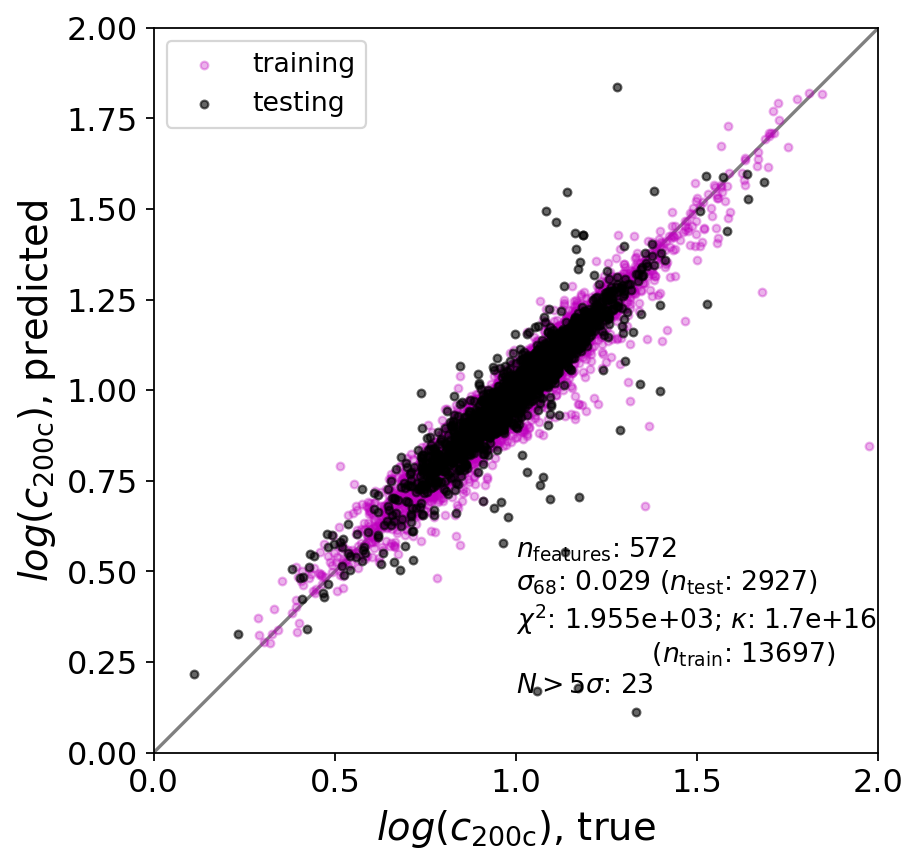

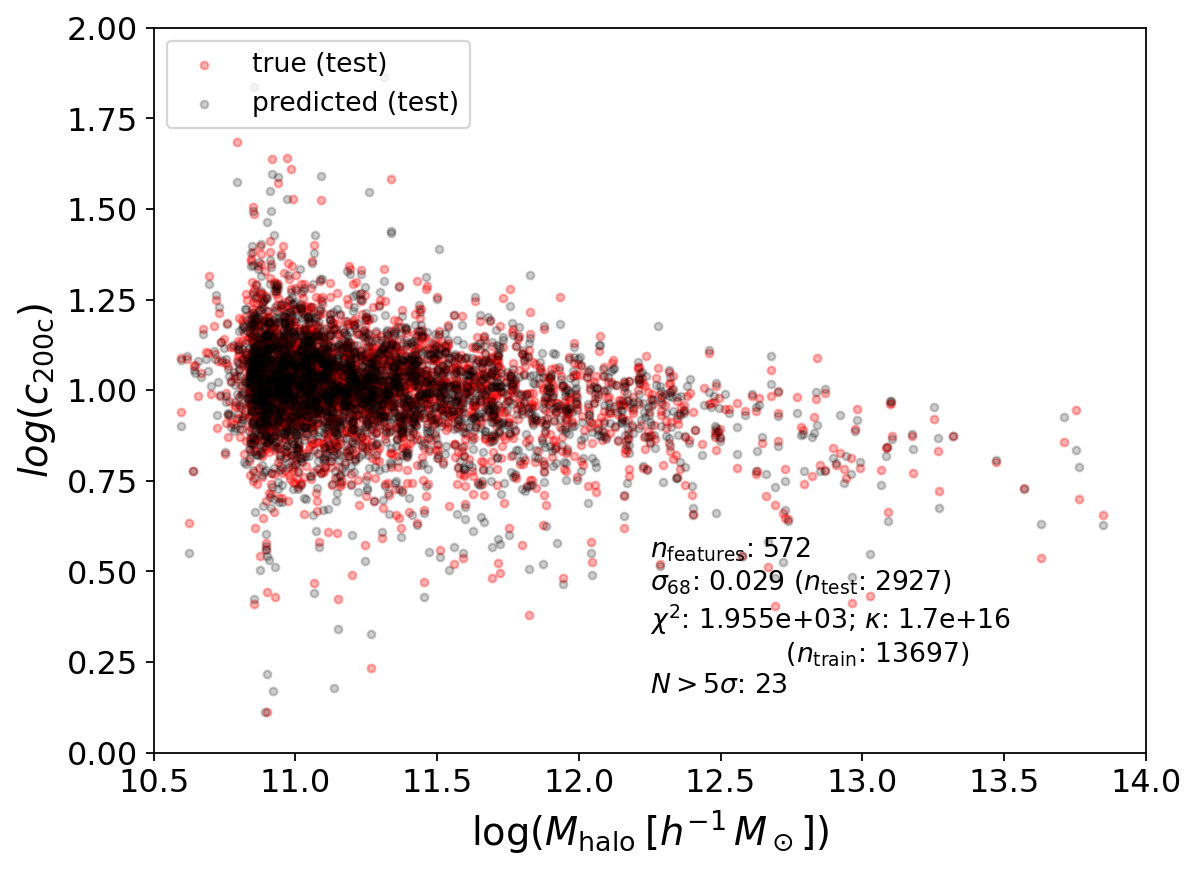

In [30]:
x_label_name = 'm_200m'
y_label_name = 'c_200c'

fitter_all = LinearFitter(scalar_featurizer.scalar_features[idx_notnan], log_c200c, 
                    y_val_current_c200c, uncertainties=uncertainties_c200c,
                    x_features_extra=x_features_extra[idx_notnan])
fitter_all.split_train_test(idx_train, idx_val)
fitter_all.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter_all.predict_test()
plotter.plot_fits(x_label_name, y_label_name, fitter_all, log_m_200m, x_lim=(10.5,14),  y_lim=(0,2))
error_all, _ = utils.compute_error(fitter_all, test_error_type='percentile')
print(error_all)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:278: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


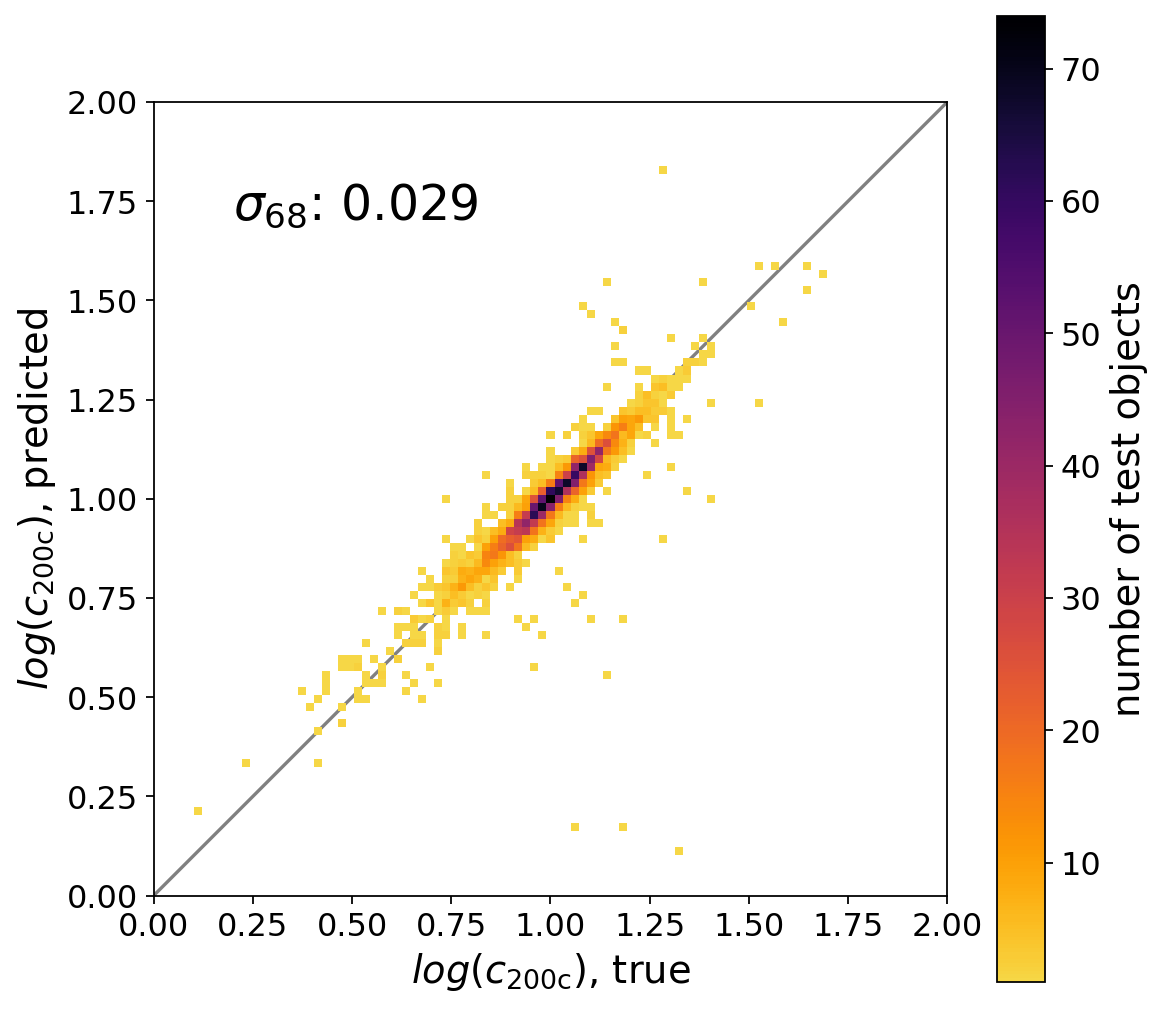

In [31]:
y_true = fitter_all.y_scalar_test
y_pred = fitter_all.y_scalar_pred
error_str = fr"$\sigma_{{68}}$: {error_all:.3f}"
plotter.plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str,
                               x_lim=(0,2),  y_lim=(0,2))

# Check out dynamical accretion rate

In [32]:
M_acc = x_catalog_features[:,3]

Text(0, 0.5, 'number per bin')

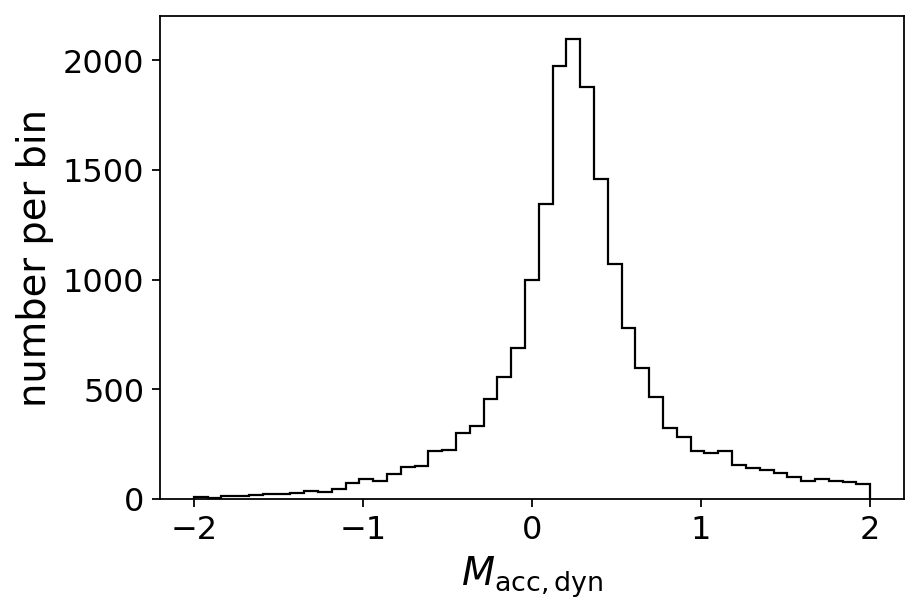

In [33]:
bins = np.linspace(-2,2,50)
plt.hist(M_acc, bins=bins, histtype='step', color='k')
plt.xlabel(r'$M_\mathrm{acc,dyn}$')
plt.ylabel('number per bin')

Text(0, 0.5, '$M_\\mathrm{acc,dyn}$')

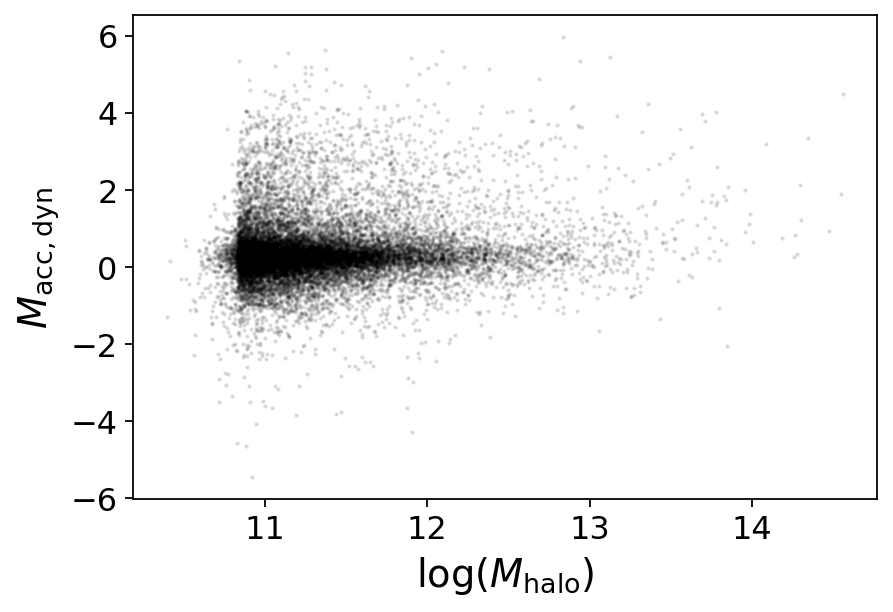

In [34]:
plt.scatter(log_m_200m[idx_notnan]+log_mass_shift, M_acc, s=1, c='k', alpha=0.1)
plt.xlabel(r'log($M_\mathrm{halo}$)')
plt.ylabel(r'$M_\mathrm{acc,dyn}$')
#plt.ylim(0, 1)

In [35]:
uncertainties_Macc = 0.1 * M_acc

In [36]:
y_val_current_Macc = np.ones(len(M_acc))

0.44329874965013644


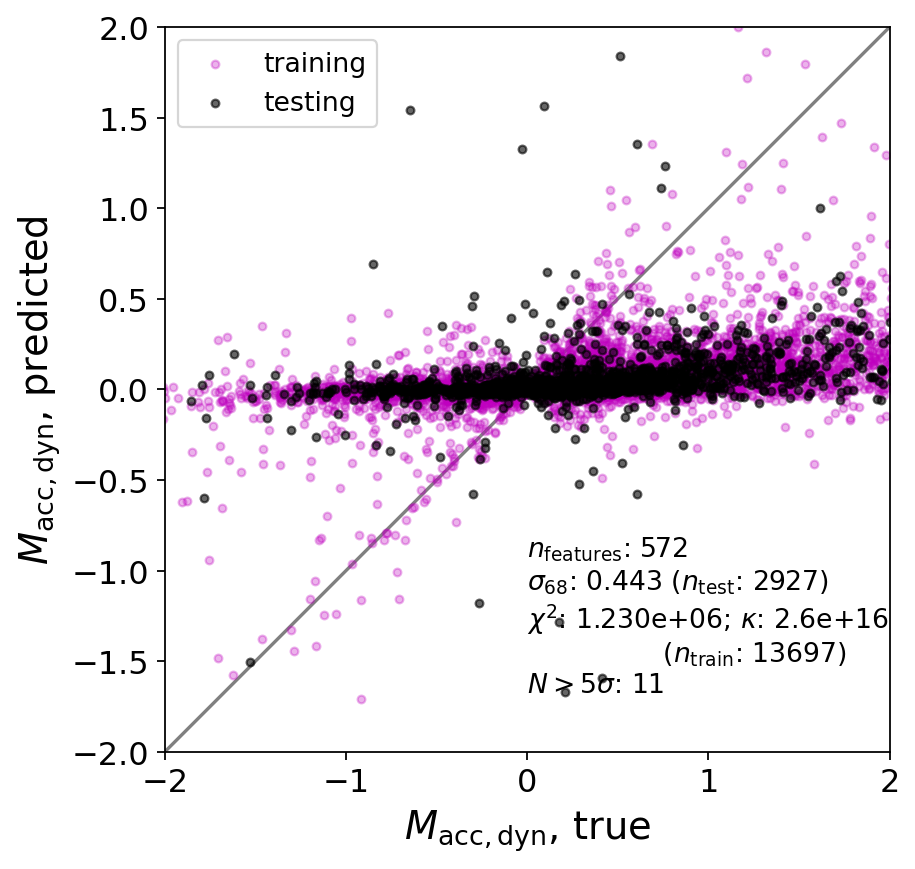

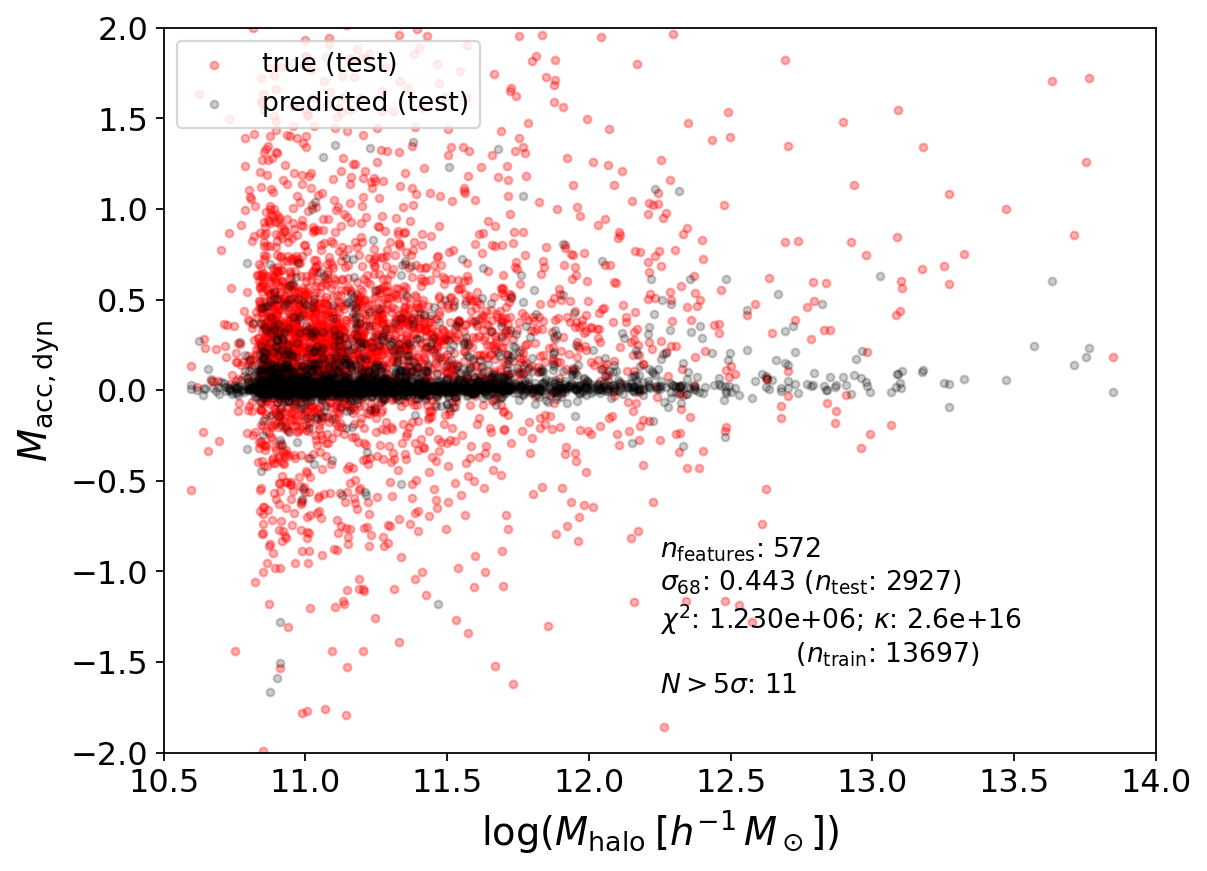

In [37]:
x_label_name = 'm_200m'
y_label_name = 'M_acc'

fitter_all = LinearFitter(scalar_featurizer.scalar_features[idx_notnan], M_acc, 
                    y_val_current_Macc, uncertainties=uncertainties_Macc,
                    x_features_extra=x_features_extra[idx_notnan])
fitter_all.split_train_test(idx_train, idx_val)
fitter_all.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter_all.predict_test()
plotter.plot_fits(x_label_name, y_label_name, fitter_all, log_m_200m, x_lim=(10.5,14),  y_lim=(-2,2))
error_all, _ = utils.compute_error(fitter_all, test_error_type='percentile')
print(error_all)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:278: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


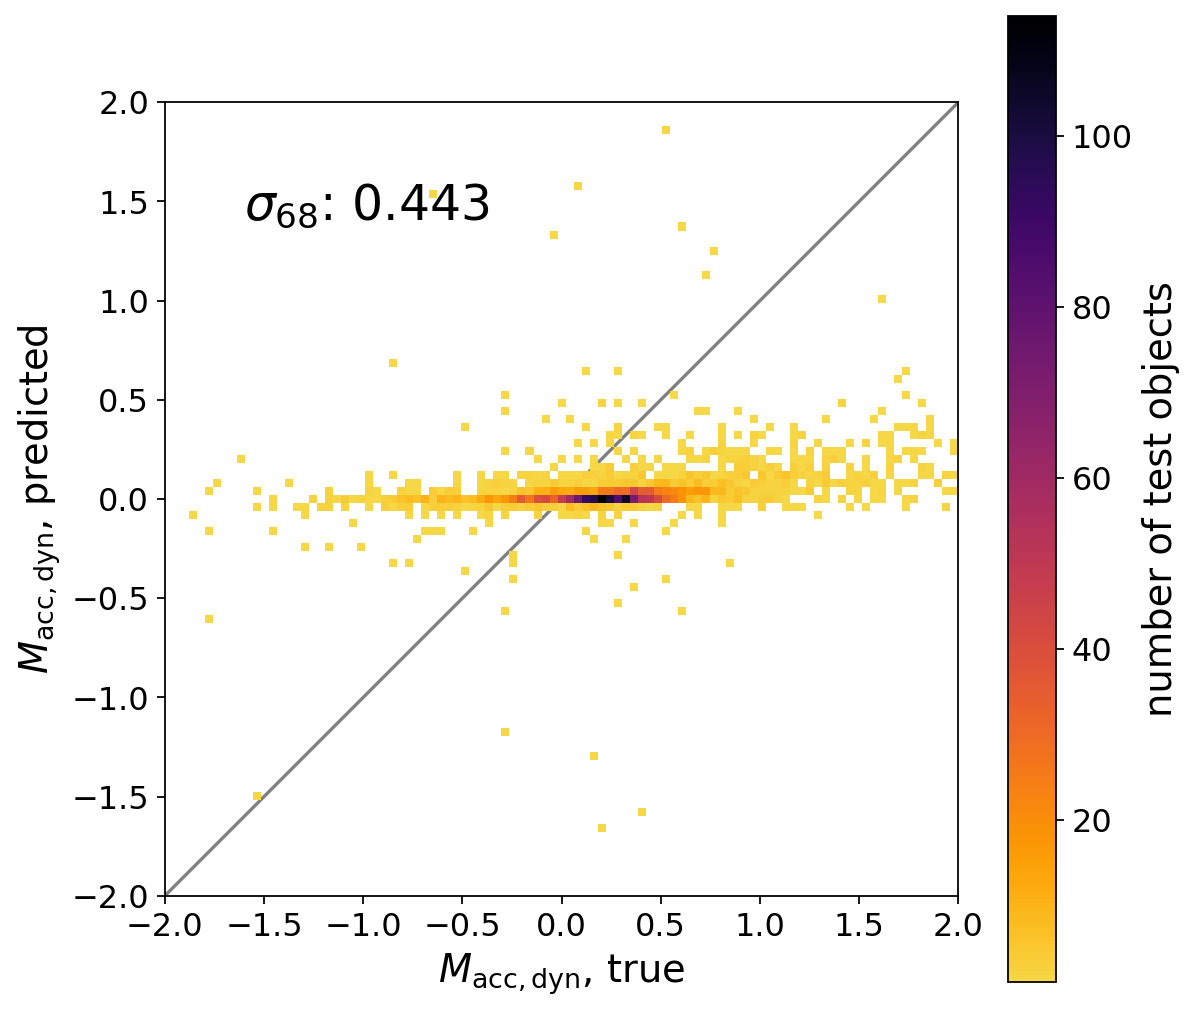

In [38]:
y_true = fitter_all.y_scalar_test
y_pred = fitter_all.y_scalar_pred
error_str = fr"$\sigma_{{68}}$: {error_all:.3f}"
plotter.plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str,
                               x_lim=(-2, 2),  y_lim=(-2,2))

oop guess not!